# Data Cleaning in Python: Working with MTA Turnstile Data
### Why clean your data?
- It makes everything easier
- It makes your analyses and models more accurate
- It's kind of required for most projects..
- A lot of datasets are SUPER MESSY, like the one we're using today from the MTA

### What dataset are we using? Why?

This dataset is released every week, and consists of observations for every single turnstile in the MTA's subway network, for every 4 hours from the previous Sunday to Saturday. The dataset contains cumulative entries and exits from those turnstiles. For users who want to look at subway usage data, this is one of the only ways, and it is also incredibly difficult to comprehend at first. See: http://web.mta.info/developers/turnstile.html

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import matplotlib as plt
%matplotlib inline

## Setting a date range
Note the format of the csv URLs: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181124.txt

The last part is a date, the thru date, 18-11-24, Nov 24, 2018.
We want more than just one week's worth of data, so we'll create an array of dates in our range using a pandas function called date_range. 

Then, we'll create an array of URLs using the dates in the format the MTA uses, so that we can pull multiple CSVs at once. 

In [3]:
dates_raw = pd.date_range(date(2019,9,1), date.today(), freq="W-SAT")

dates = []
for d in dates_raw:
    dates.append(d.strftime("%y%m%d"))

print("dates_raw: ",dates_raw)
print("dates: ", dates)

dates_raw:  DatetimeIndex(['2019-09-07', '2019-09-14', '2019-09-21', '2019-09-28',
               '2019-10-05'],
              dtype='datetime64[ns]', freq='W-SAT')
dates:  ['190907', '190914', '190921', '190928', '191005']


In [4]:
def create_url(date):
        base_url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
        ext = ".txt"
        url = base_url + date + ext
        return url
    
urls = []
for i in dates:
    urls.append(create_url(i))
    
# Show first two urls in list
print(urls[0:2])

['http://web.mta.info/developers/data/nyct/turnstile/turnstile_190907.txt', 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190914.txt']


## Creating a dataframe

In [5]:
df = pd.DataFrame()

for u in urls:
    df = pd.concat([df, pd.read_csv(u, parse_dates=[[6,7]])])
    
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2019-08-31 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183242,2433142
1,2019-08-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183258,2433149
2,2019-08-31 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183278,2433176
3,2019-08-31 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183393,2433262
4,2019-08-31 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183572,2433312


In [6]:
df['DATE_TIME'].head()

0   2019-08-31 00:00:00
1   2019-08-31 04:00:00
2   2019-08-31 08:00:00
3   2019-08-31 12:00:00
4   2019-08-31 16:00:00
Name: DATE_TIME, dtype: datetime64[ns]

In [7]:
df.ENTRIES.head()

0    7183242
1    7183258
2    7183278
3    7183393
4    7183572
Name: ENTRIES, dtype: int64

In [8]:
df['EXITS'].head()

KeyError: 'EXITS'

In [9]:
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

## Cleaning the data
First, we'll clean up the column names. Then we'll work through some common issues in this dataset.

In [10]:
cleaned_columns = []

for column in df.columns:
    c = column.strip()
    cleaned_columns.append(c)
    
print(cleaned_columns)

['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DESC', 'ENTRIES', 'EXITS']


In [11]:
df.columns = cleaned_columns
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2019-08-31 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183242,2433142
1,2019-08-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183258,2433149
2,2019-08-31 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183278,2433176
3,2019-08-31 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183393,2433262
4,2019-08-31 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7183572,2433312


### Aggregating by station
Right now, every observation represents one turnstile at one station at a particular date and time, with the cumulative entries and exits. However, we don't really care about individual turnstiles. They actually make it harder to read our data. For example, there will be more than 10 observations at the 116th street 1 station on 9/29/18 at 4 am alone. Instead, we'll group the data by station, line name, date, and time to find the sum of cumulative entries and exits. 

In [12]:
df_grouped = df.groupby(['STATION','LINENAME', 'DATE_TIME'])[['ENTRIES', 'EXITS']].agg('sum')
df_grouped.reset_index(inplace=True)

In [13]:
df_grouped.head()

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS
0,1 AV,L,2019-08-31 00:00:00,1415101561,1465508502
1,1 AV,L,2019-08-31 04:00:00,1415101931,1465508896
2,1 AV,L,2019-08-31 08:00:00,1415102094,1465509366
3,1 AV,L,2019-08-31 12:00:00,1415102790,1465510479
4,1 AV,L,2019-08-31 16:00:00,1415104147,1465512338


### Removing entries at odd times

In [14]:
pd.options.display.float_format = '{:.1f}'.format
df_grouped[140:150]

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS
140,1 AV,L,2019-09-23 08:00:00,1415397916,1465842677
141,1 AV,L,2019-09-23 12:00:00,1415402432,1465847813
142,1 AV,L,2019-09-23 16:00:00,1415406731,1465851273
143,1 AV,L,2019-09-23 20:00:00,1415412426,1465857127
144,1 AV,L,2019-09-24 00:00:00,1415414361,1465858888
145,1 AV,L,2019-09-24 04:00:00,1415414526,1465859066
146,1 AV,L,2019-09-24 08:00:00,1415415910,1465861770
147,1 AV,L,2019-09-24 10:44:54,455305897,444168690
148,1 AV,L,2019-09-24 12:00:00,1415420208,1465866773
149,1 AV,L,2019-09-24 16:00:00,1415424418,1465870521


This particular section has a couple of problems. Not only is the entry/exit counter resetting, but if you look closely at the datetimes, you'll notice that some of the observations are not 4 hours apart. First, we'll create a variable for the difference in time between an observation and the following observation. Then, we'll need to remove an observation if it's time difference is not 4, AND if the one after is also not 4. This is because we wouldn't want to drop the 9/24 observation at 12 pm, but we would want to drop the 9/24 observation at 10:44 am.

In [15]:
df_grouped['timedif'] = df_grouped.DATE_TIME.diff().dt.seconds/(60.**2.)

In [16]:
df_grouped.head()

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS,timedif
0,1 AV,L,2019-08-31 00:00:00,1415101561,1465508502,nan
1,1 AV,L,2019-08-31 04:00:00,1415101931,1465508896,4.0
2,1 AV,L,2019-08-31 08:00:00,1415102094,1465509366,4.0
3,1 AV,L,2019-08-31 12:00:00,1415102790,1465510479,4.0
4,1 AV,L,2019-08-31 16:00:00,1415104147,1465512338,4.0


In [17]:
len(df_grouped)

164053

In [18]:
drop_these = []
limit = len(df_grouped) - 2

for row in df_grouped.iterrows():
    i = row[0]
    if i > limit:
        break
    timedif = row[1][5]
    next_timedif = df_grouped.iloc[i + 1].timedif.item()
    if (timedif != 4) and (next_timedif != 4):
        drop_these.append(row[0])

In [19]:
df_grouped.reset_index(inplace = True, drop = True)

In [20]:
df_grouped.loc[drop_these]

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS,timedif
147,1 AV,L,2019-09-24 10:44:54,455305897,444168690,2.7
178,1 AV,L,2019-09-29 11:18:06,455343900,444193548,3.3
467,103 ST,6,2019-09-07 10:26:49,47997401,56537779,1.4
485,103 ST,6,2019-09-10 07:08:25,48022627,56562081,2.1
486,103 ST,6,2019-09-10 07:09:45,48022651,56562134,0.0
487,103 ST,6,2019-09-10 07:11:06,48022681,56562155,0.0
488,103 ST,6,2019-09-10 07:12:25,48022694,56562164,0.0
489,103 ST,6,2019-09-10 07:13:45,48022713,56562179,0.0
490,103 ST,6,2019-09-10 07:15:06,48022732,56562180,0.0
491,103 ST,6,2019-09-10 07:16:26,48022755,56562241,0.0


In [21]:
len(drop_these)/len(df_grouped)

0.42187585719249265

In [22]:
df_grouped[140:150]

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS,timedif
140,1 AV,L,2019-09-23 08:00:00,1415397916,1465842677,4.0
141,1 AV,L,2019-09-23 12:00:00,1415402432,1465847813,4.0
142,1 AV,L,2019-09-23 16:00:00,1415406731,1465851273,4.0
143,1 AV,L,2019-09-23 20:00:00,1415412426,1465857127,4.0
144,1 AV,L,2019-09-24 00:00:00,1415414361,1465858888,4.0
145,1 AV,L,2019-09-24 04:00:00,1415414526,1465859066,4.0
146,1 AV,L,2019-09-24 08:00:00,1415415910,1465861770,4.0
147,1 AV,L,2019-09-24 10:44:54,455305897,444168690,2.7
148,1 AV,L,2019-09-24 12:00:00,1415420208,1465866773,1.3
149,1 AV,L,2019-09-24 16:00:00,1415424418,1465870521,4.0


In [23]:
df_grouped.drop(drop_these, inplace = True)
df_grouped[140:150]

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS,timedif
140,1 AV,L,2019-09-23 08:00:00,1415397916,1465842677,4.0
141,1 AV,L,2019-09-23 12:00:00,1415402432,1465847813,4.0
142,1 AV,L,2019-09-23 16:00:00,1415406731,1465851273,4.0
143,1 AV,L,2019-09-23 20:00:00,1415412426,1465857127,4.0
144,1 AV,L,2019-09-24 00:00:00,1415414361,1465858888,4.0
145,1 AV,L,2019-09-24 04:00:00,1415414526,1465859066,4.0
146,1 AV,L,2019-09-24 08:00:00,1415415910,1465861770,4.0
148,1 AV,L,2019-09-24 12:00:00,1415420208,1465866773,1.3
149,1 AV,L,2019-09-24 16:00:00,1415424418,1465870521,4.0
150,1 AV,L,2019-09-24 20:00:00,1415430250,1465876567,4.0


In [24]:
len(df_grouped)

94843

### Calculating entries and exits, non-cumulative
Cumulative entries and exits do very little for us. We would much rather know the number of entries and exits in each 4 hour period. Also, sometimes the cumulative count will reset, throwing calculations off. 

In [25]:
df_grouped['ent'] = df_grouped.groupby(['STATION', 'LINENAME'])['ENTRIES'].transform(lambda x: x.diff())
df_grouped['ext'] = df_grouped.groupby(['STATION', 'LINENAME'])['EXITS'].transform(lambda x: x.diff())
df_grouped.head()

,STATION,LINENAME,DATE_TIME,ENTRIES,EXITS,timedif,ent,ext
0,1 AV,L,2019-08-31 00:00:00,1415101561,1465508502,nan,nan,nan
1,1 AV,L,2019-08-31 04:00:00,1415101931,1465508896,4.0,370.0,394.0
2,1 AV,L,2019-08-31 08:00:00,1415102094,1465509366,4.0,163.0,470.0
3,1 AV,L,2019-08-31 12:00:00,1415102790,1465510479,4.0,696.0,1113.0
4,1 AV,L,2019-08-31 16:00:00,1415104147,1465512338,4.0,1357.0,1859.0


In [26]:
df_grouped.reset_index(drop = True,inplace=True)

### Locating and removing outliers
For data of this nature, there will be a lot of variability, because some stations get a lot more traffic than others, and some times are much busier than others. First, we'll 'describe' our ent and ext variables, to better understand their distribution. We'll find that there are some entries less than zero, which is impossible, so we'll remove observations with entries or exits less than zero.

In [31]:
#pd.options.display.float_format = '{:20, .2f}'.format

print(df_grouped['ent'].min())
print(df_grouped['ent'].max())

0.0
3627793740.0


In [30]:
df_grouped.loc[(df_grouped['ent']<0), 'ent']=np.nan
df_grouped.loc[(df_grouped['ext']<0), 'ext']=np.nan
df_grouped.reset_index(drop=True,inplace=True)

In [33]:
df_grouped.describe()

,ENTRIES,EXITS,timedif,ent,ext
count,94843.0,94843.0,94842.0,93868.0,93708.0
mean,419757462.4,343326709.6,4.0,389818.3,373675.6
std,818278593.6,776024015.8,0.2,23595386.8,24702881.9
min,0.0,65.0,0.0,0.0,0.0
25%,17542514.5,10980130.0,4.0,233.0,200.0
50%,48099478.0,26066539.0,4.0,813.0,581.0
75%,290937665.0,109962204.5,4.0,2019.0,1409.0
max,5687534213.0,5781680047.0,20.3,3627793740.0,3797637600.0


In [39]:
df_grouped.ext.median()

581.0

In [44]:
#plt.pyplot.hist(df_grouped['ent'], bins=100, range=[minent, maxent])

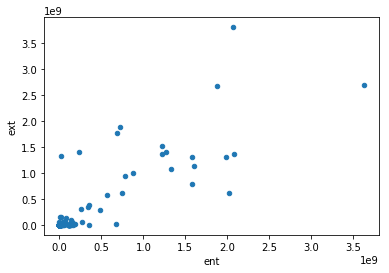

In [47]:
df_grouped.plot.scatter('ent','ext')

In [106]:
df_grouped.quantile(0.9,0)

ENTRIES   1723957457.6
EXITS     1424163823.6
timedif            4.0
ent             4040.0
ext             3208.0
Name: 0.9, dtype: float64

In [96]:
def get_dist(q):
    return df_grouped.quantile(q,0).ent

values = np.arange(0.99,1.,0.001)

dists = []

for i in values:
    result = get_dist(i)
    result = int(result)
    dists.append(result)

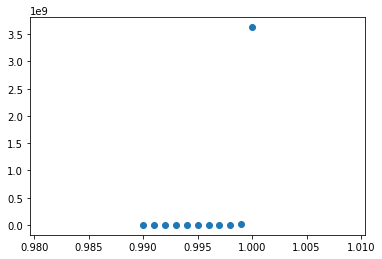

In [97]:
plt.pyplot.scatter(values, dists)

In [100]:
pd.set_option("display.precision", 8)
df = pd.DataFrame({'values':values, 'dists':dists}, dtype = "float")

In [99]:
values

array([0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999, 1.   ])

In [101]:
df.dtypes

values    float64
dists     float64
dtype: object

In [102]:
with pd.option_context("display.float_format", "{:20f}".format):
    print(df)

                 values                dists
0              0.990000         14733.000000
1              0.991000         15611.000000
2              0.992000         16789.000000
3              0.993000         18769.000000
4              0.994000         21011.000000
5              0.995000         24904.000000
6              0.996000         31767.000000
7              0.997000        569948.000000
8              0.998000       4871515.000000
9              0.999000      19733075.000000
10             1.000000    3627793740.000000


In [110]:
max_ent = df_grouped.quantile(0.997,0).ent
max_ext = df_grouped.quantile(0.997,0).ext

df_grouped2 = df_grouped[(df_grouped.ent < max_ent) & (df_grouped.ext < max_ext)]

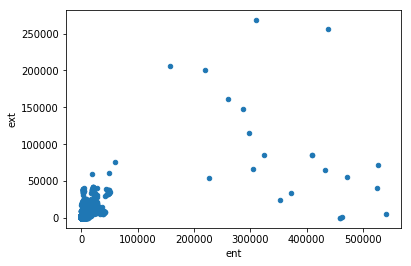

In [114]:
df_grouped2.plot.scatter('ent','ext')

In [115]:
df_grouped2.describe()

,ENTRIES,EXITS,timedif,ent,ext
count,93281.0,93281.0,93281.0,93281.0,93281.0
mean,414220047.9,336936490.6,4.0,1744.4,1334.2
std,815595823.9,771192254.6,0.2,6530.6,3048.8
min,413676.0,13572.0,0.0,0.0,0.0
25%,17478661.0,10965544.0,4.0,234.0,200.0
50%,47363681.0,25998627.0,4.0,813.0,578.0
75%,271375081.0,100584841.0,4.0,2007.0,1396.0
max,5687534213.0,5781680047.0,20.3,540201.0,268089.0
